In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#configure API key
quandl.ApiConfig.api_key = '2zxa97zMuaSTDZJt1syL'

In [3]:
#load quandl dataset
data = quandl.get('FRED/NROU')

In [4]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [5]:
data.shape

(332, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

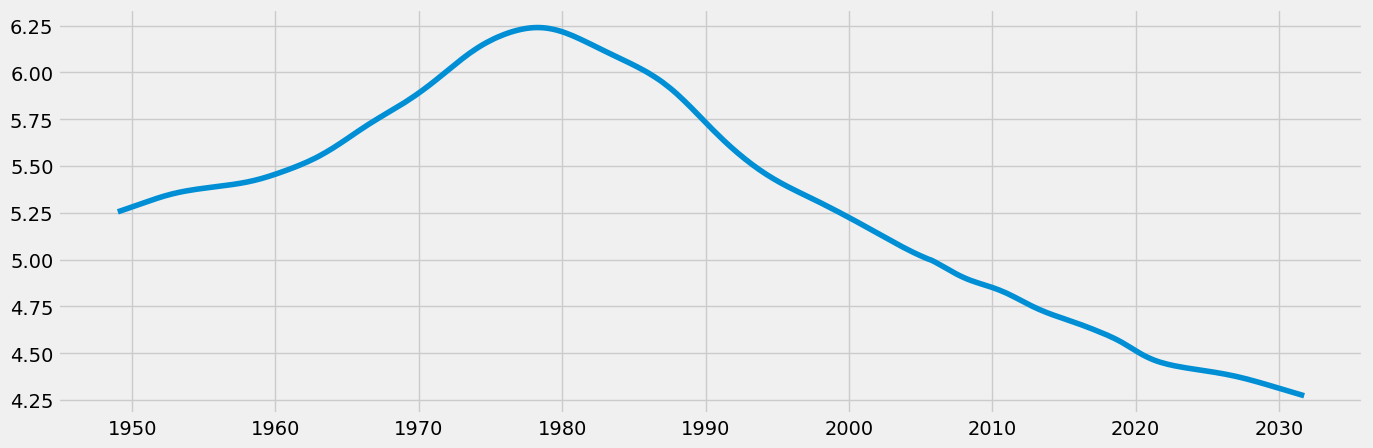

In [8]:
#plot the data with matplotlib

plt.figure(figsize=(15,5),dpi=100)
plt.plot(data)

In [9]:
#reset index to use the data column as a filter
data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [11]:
#create subset of data with only records between 1980 and 2020
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [12]:
data_sub.shape

(162, 2)

In [13]:
data_sub.head()

,Date,Value
124,1980-01-01,6.217371
125,1980-04-01,6.210709
126,1980-07-01,6.203388
127,1980-10-01,6.195496
128,1981-01-01,6.187123


In [14]:
#reset the date column as the index
from datetime import datetime
data_sub['datetime']=pd.to_datetime(data_sub['Date']) #creates a datetime column from 'date'
data_sub=data_sub.set_index('datetime') #sets the datetime as the index of the dataframe
data_sub.drop(['Date'], axis=1, inplace=True) #drops the 'date' column

In [15]:
data_sub.head()

,Value
datetime,
1980-01-01,6.217371
1980-04-01,6.210709
1980-07-01,6.203388
1980-10-01,6.195496
1981-01-01,6.187123


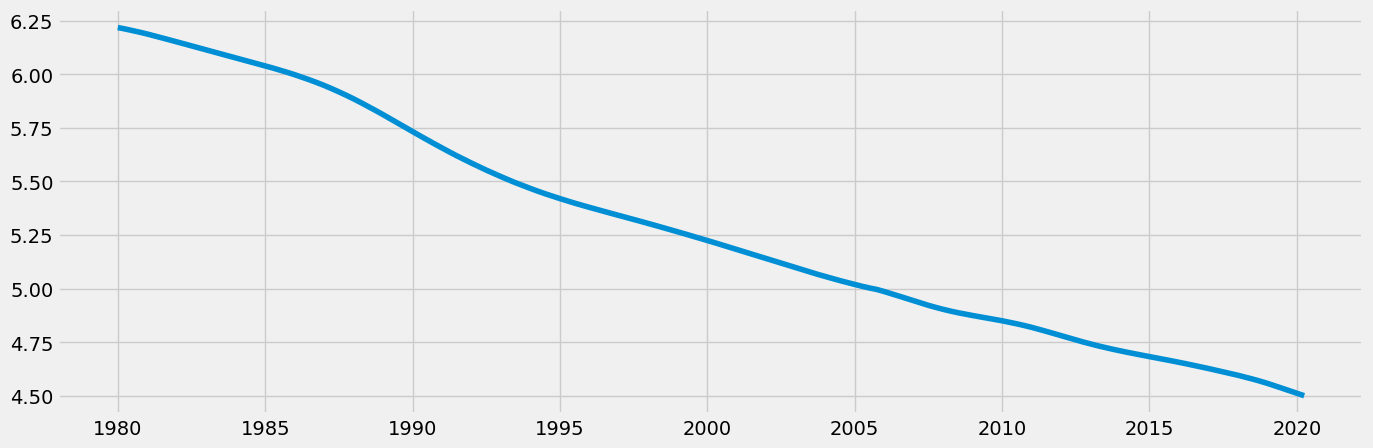

In [16]:
#plot the new dataset
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [17]:
#check for missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [18]:
#check for duplicates
dups=data_sub.duplicated()
dups.sum()

0

In [19]:
#decompose the time series through an additive model
decomposition=sm.tsa.seasonal_decompose(data_sub,model='additive')

In [20]:
#define a fixed size for all special charts
from pylab import rcParams
rcParams['figure.figsize']=18,7

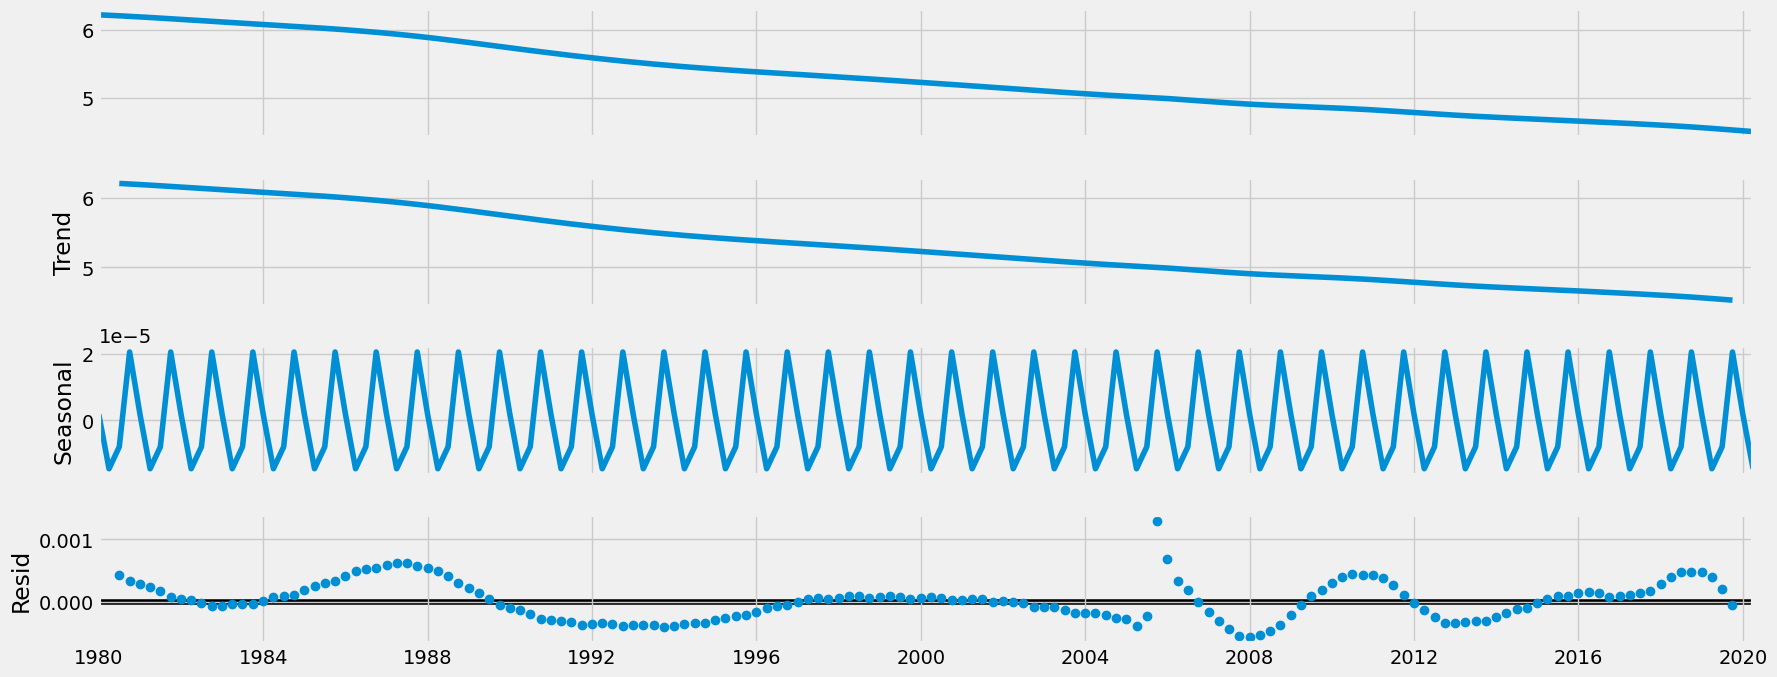

In [21]:
#plot the separate components
decomposition.plot()
plt.show()

In [23]:
#check for stationarity using dickey fuller test
from statsmodels.tsa.stattools import adfuller #imports the adfuller() function
def dickey_fuller(timeseries): #defines the function
    #performsthe dickey-fuller test:
    print('Dickey-Fuller Stationarity test:')
    test=adfuller(timeseries,autolag='AIC')
    result=pd.Series(test[0:4],index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key]=value
    print(result)
#applies the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.745331
p-value                          0.407921
Number of Lags Used              4.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


The null hypothesis being the presence of a unit root (we want to disprove that there is a unit root, which would mean the data is stationary), the critical value being smaller than the test statistic means we cannot reject the null hypothesis and that this data is non-stationary.

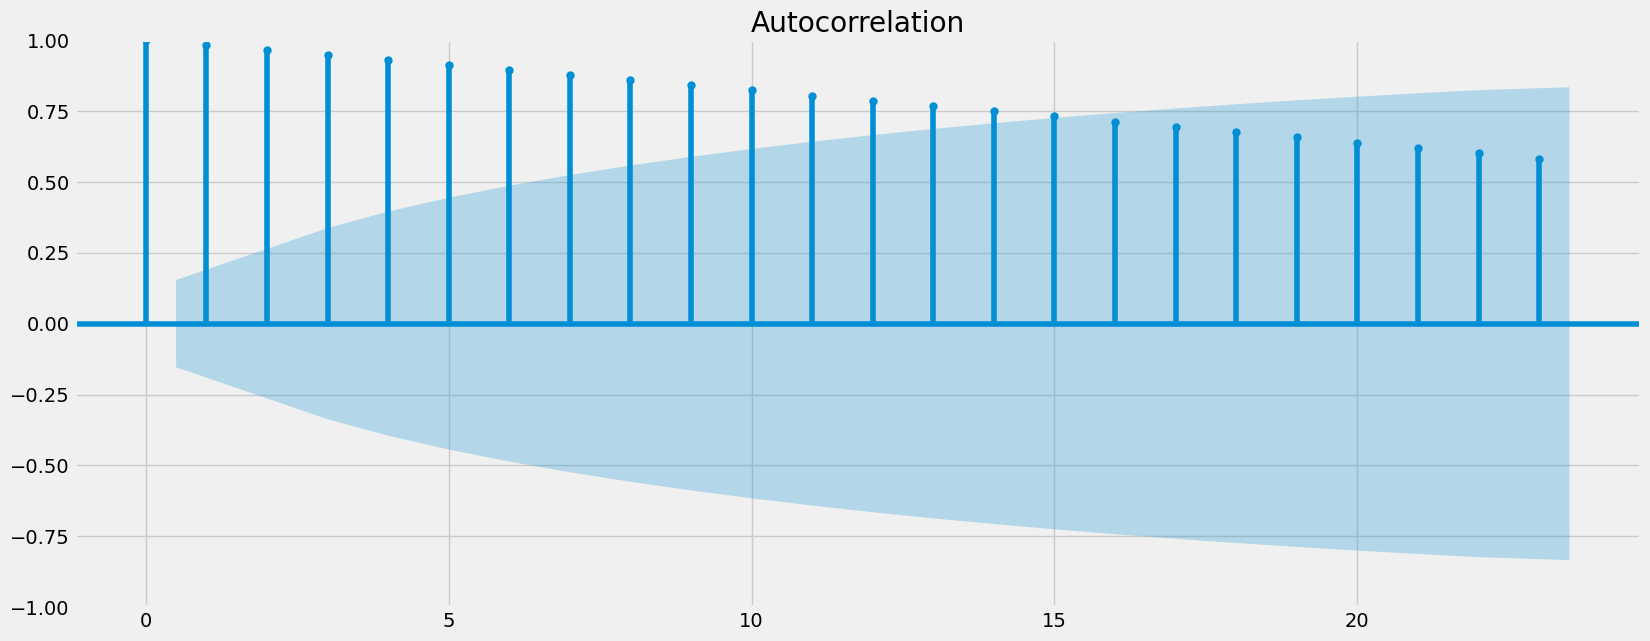

In [24]:
#check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #imports the autocorrelation and partial correlation plots
plot_acf(data_sub)
plt.show()

Vertical lines represent the lags in the series, the blue area represents the confidence interval. Lines going above the blue edge of the confidence interval means they are significantly correlated with each other. A large amount of lags beyond this interval leads to a deducion that the data is non-stationary. In this case, there are several lags correlated with each other, showing that there is autocorrelation in the data. This further supports the assertion that the dataset is non-stationary, corroborating the Dickey-Fuller test results.

In [25]:
#calculate difference between every value and its lag and store the results in a new df
data_diff=data_sub-data_sub.shift(1)

In [26]:
#remove any missing values resulting from the subtraction
data_diff.dropna(inplace=True)

In [27]:
data_diff.head()

,Value
datetime,
1980-04-01,-0.006662
1980-07-01,-0.007321
1980-10-01,-0.007892
1981-01-01,-0.008373
1981-04-01,-0.008762


In [28]:
data_diff.columns

Index(['Value'], dtype='object')

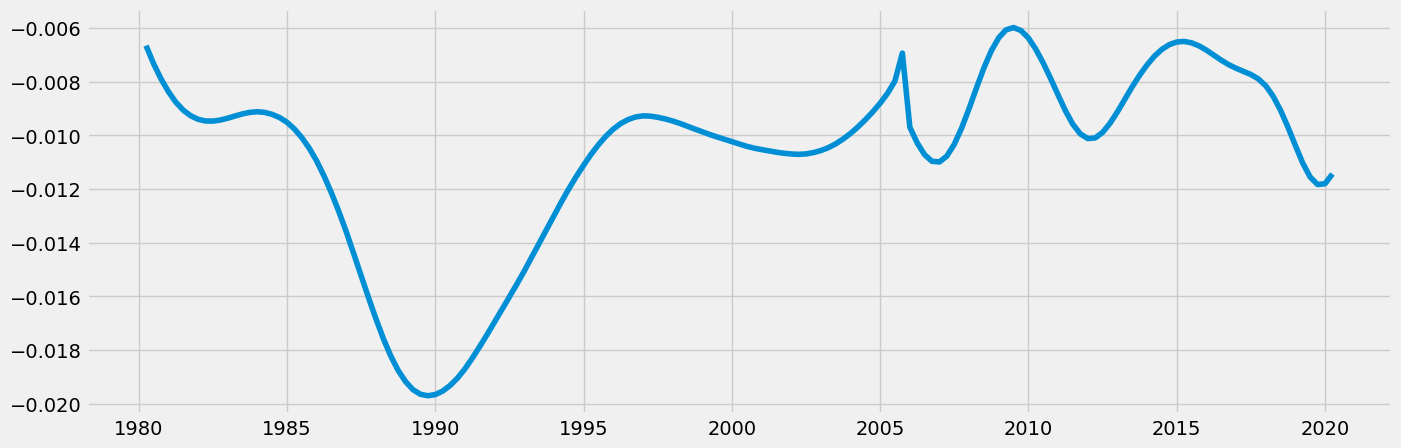

In [29]:
#plot time series curve of dataset after differencing
plt.figure(figsize=(15,5),dpi=100)
plt.plot(data_diff)

In [32]:
#check for stationarity using dickey fuller test
from statsmodels.tsa.stattools import adfuller #imports the adfuller() function
def dickey_fuller(timeseries): #defines the function
    #performsthe dickey-fuller test:
    print('Dickey-Fuller Stationarity test:')
    test=adfuller(timeseries,autolag='AIC')
    result=pd.Series(test[0:4],index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)'%key]=value
    print(result)
#applies the test using the function on the time series
dickey_fuller(data_diff['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.451840
p-value                          0.127636
Number of Lags Used              2.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64


Contrary to the example of the exercise, the Dickey-Fuller test continues suggesting the data as non-stationary.

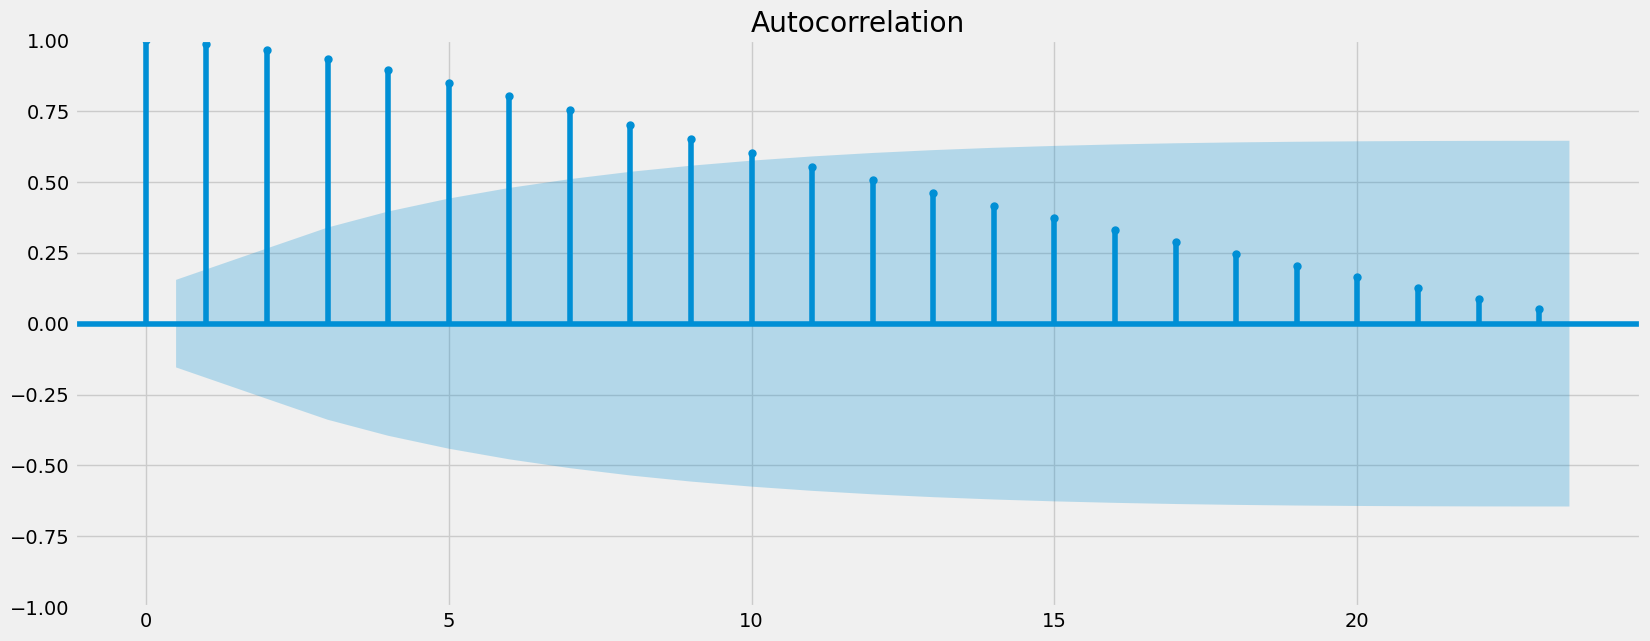

In [33]:
#check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf #imports the autocorrelation and partial correlation plots
plot_acf(data_diff)
plt.show()